## **Can experience and age predict the played hours in the player dataset?**
By:Olivia Cheng, Kayleigh Mitford,Hassan Qureshi & Joon Rhee

## Introduction



   In this project, the data set that we were using was from a research group in Computer Science at UBC, led by Frank Wood. They collected the data through a MineCraft server where player’s actions were recorded. They needed to know what “kind” of players are most likely to contribute the most in order to make sure they have enough resources to target those players in their recruiting efforts. Therefore, the question we are trying to answer is “Can experience and age predict the played hours in the player dataset?”. The data set that we used to answer the question was players.csv. In this dataset, there are 196 observations and 7 variables. In those 7 variables, there were 2 quantitative variables and 5 categorical variables. The 2 quantitative variables are “played_hours” and “Age”. “played_hours” told us the number of hours each player spent playing the game. “Age” represented the age of each player. The 5 categorical variables are “hashedEmail”, “name”, “experience”, “Subscribe”, and “Gender”. “hashedEmail” is the email of each player. “name” showed us the name of the players. “experience” indicated the experience of the players (Beginner, Amateur, Veteran or Pro). “Subscribe” told us whether or not the players were subscribing to a game-related newsletter (TRUE/FALSE). “Gender” told us the gender of the players (female/male/non-binary/two-spirited/prefer not to say). In order to answer our question, we focused on using the variables “experience” “Age”, "played_hours" to help us predict whether a player is a high/low contributor as we believed that whichever type of player have the highest played hours would contribute the most.

In [1]:
# Libraries must be loaded in

library(tidyverse)
library(repr)
library(tidymodels)
library(GGally)
library(ISLR)


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

### Loading in and tidying the data set

In [2]:
players <- read_csv("https://raw.githubusercontent.com/dsci100projectonly/dataforproject/refs/heads/main/players.csv")
players <- players |> mutate(experience = as.factor(experience)) |> drop_na() 
## NA values that were deemed to not have a suitable reason to be present is being dropped
## Representing experience as a factor is more suitable for its limited classifications
players <- players |> select(Age, experience, played_hours)
## Selecting only the relevant variables to answer the posed question of this project
head(players)
tail(players)
## Utilizing head() and tail() function to reduce output for easier reading and analysis





Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Age,experience,played_hours
<dbl>,<fct>,<dbl>
9,Pro,30.3
17,Veteran,3.8
17,Veteran,0.0
21,Amateur,0.7
21,Regular,0.1
17,Amateur,0.0


Age,experience,played_hours
<dbl>,<fct>,<dbl>
17,Amateur,0.0
20,Amateur,0.0
17,Amateur,0.0
22,Veteran,0.3
17,Amateur,0.0
17,Amateur,2.3


## Summary of Dataset

The dataset was collected from a Minecraft server and made publicly available for this academic project. It consists of behavioral data on Minecraft players, including three main features:

- `Age`: The age of the player  
- `experience`: The player’s self-reported gaming experience level (categorical: e.g., beginner, intermediate, expert)  
- `played_hours`: The total number of hours the player has spent on the server  

In total, the dataset includes over 190 player records. The target variable (`contributor`) is derived by classifying each player as a **High** or **Low** contributor based on whether their played hours are above or below the median of all players.

This classification problem is well-suited for a **KNN model**, as it relies on identifying local similarity patterns among players in terms of behavior and background.

In [3]:
# Calculate the median of played_hours
median_hours <- median(players$played_hours)

# Create a binary target: "High" if played_hours > median, else "Low"
players <- players |>
  mutate(contributor = if_else(played_hours > median_hours, "High", "Low"))|>
 # Convert the target variable to a factor
  mutate(contributor = as.factor(contributor))

# Check the distribution of the new target variable
table(players$contributor)


High  Low 
  76  118 

## Summary Statistics

In [4]:
# 1. Summary table: Mean values and counts by contributor group
players_summary <- players |>
  group_by(contributor) |>
  summarise(
    mean_age = mean(Age),
    mean_played_hours = mean(played_hours),
    count = n()  # count of players in each group
  )

# 2. Experience level distribution within contributor groups
experience_distribution <- players %>%
  count(contributor, experience) %>%
  pivot_wider(names_from = experience, values_from = n, values_fill = list(n = 0))

# Print experience distribution table
experience_distribution


contributor,Amateur,Beginner,Pro,Regular,Veteran
<fct>,<int>,<int>,<int>,<int>,<int>
High,25,16,9,13,13
Low,38,19,4,22,35


## Preliminary Visualizations

Prior to performing classification in order to address our question, we will plot a preliminary visualization in order to observe the relationships between the chosen variables which will provide certain insights regarding the current question and whether it can help find players that contribute most to the game. A line plot of played_hours vs Age will be plotted and coloured by the variable of experience, as well as an identical line plot on the x and y-axis but coloured by contributor.

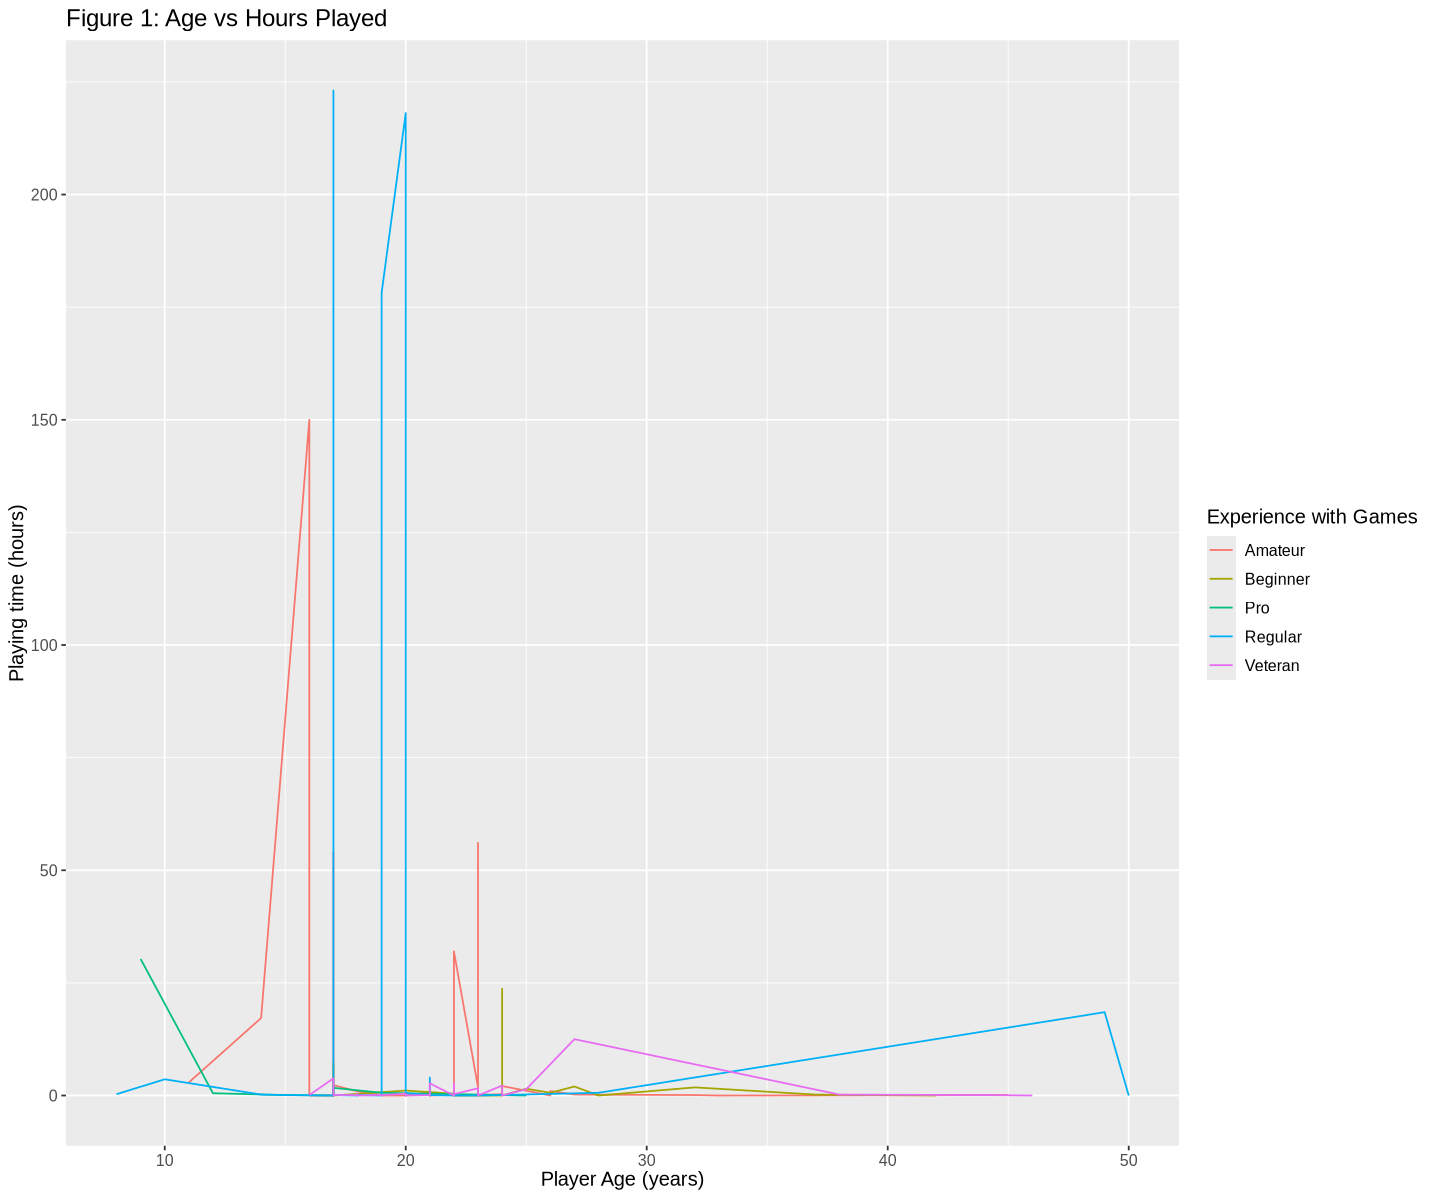

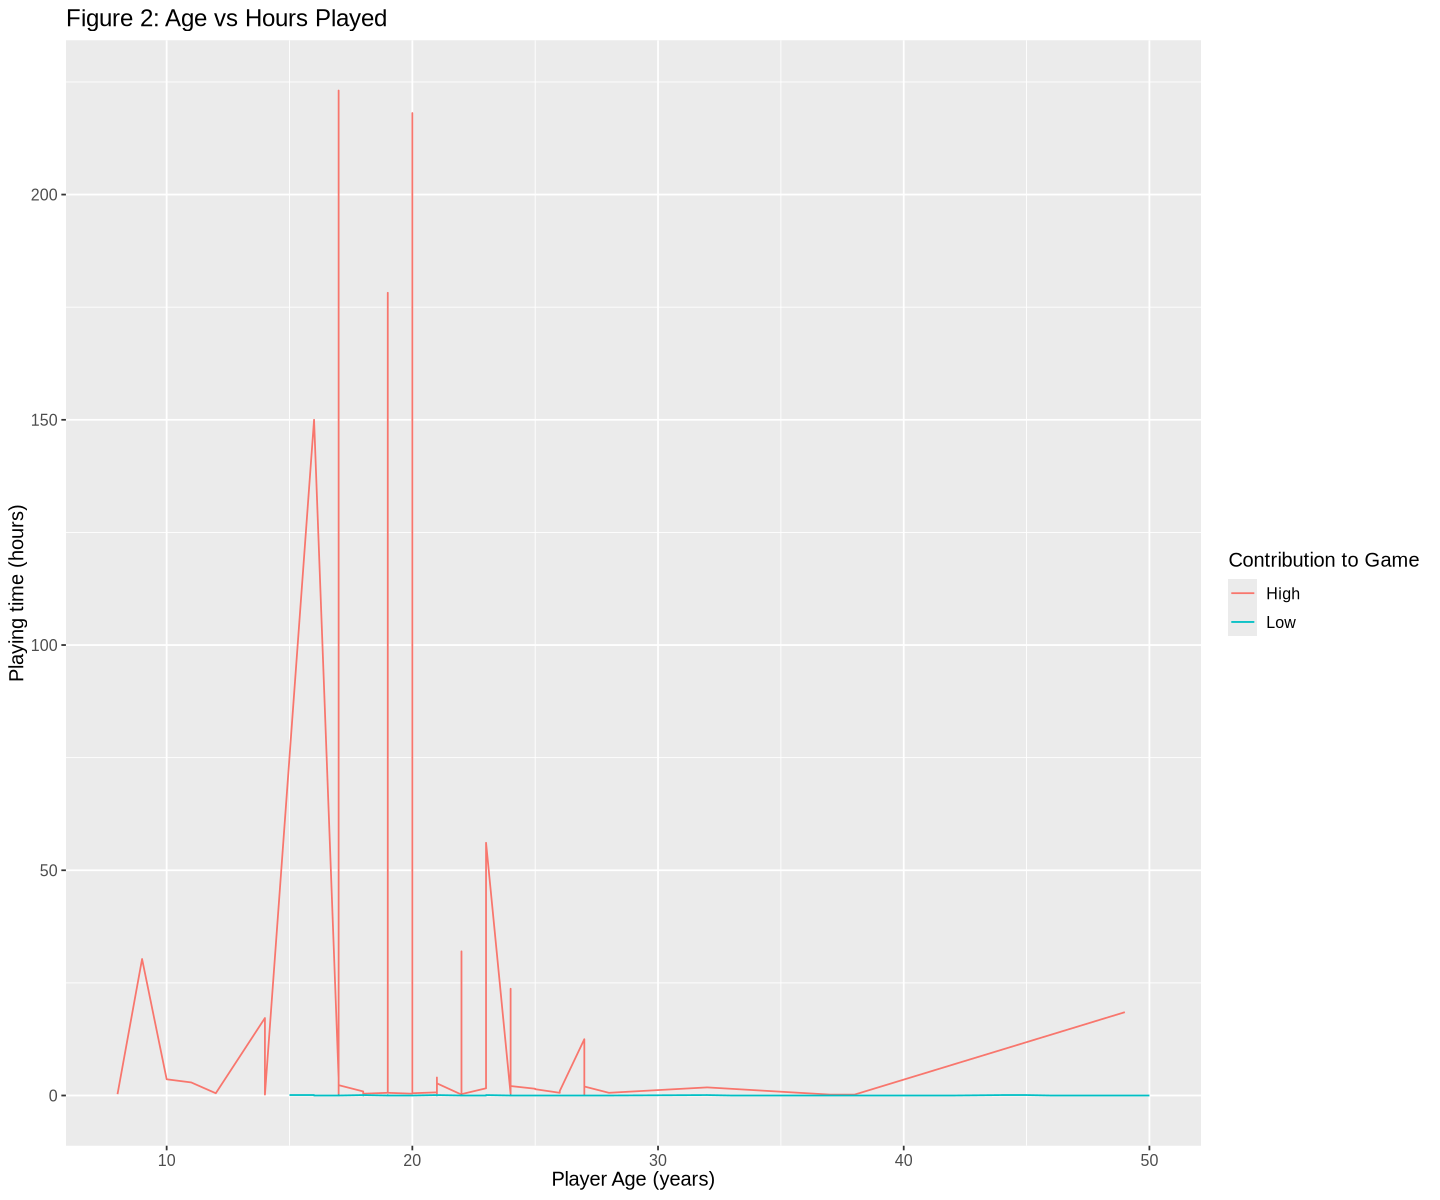

In [5]:
# Preliminary visualization 1: Line plot to observe whether there is a relationship between age and played_hours, coloured by experience.

options(repr.plot.height = 10, repr.plot.width = 12)

hours_vs_age_and_experience <- players |> ggplot(aes(x = Age, y = played_hours, colour = experience)) +
                           geom_line() +
                           labs(title = "Figure 1: Age vs Hours Played" ,x = "Player Age (years)", y = "Playing time (hours)", colour = "Experience with Games") +
                           theme(text = element_text(size =12))
hours_vs_age_and_experience

hours_vs_age_and_contributor <- players |> ggplot(aes(x = Age, y = played_hours, colour = contributor)) +
                           geom_line() +
                           labs(title = "Figure 2: Age vs Hours Played" ,x = "Player Age (years)", y = "Playing time (hours)", colour = "Contribution to Game") +
                           theme(text = element_text(size =12))
hours_vs_age_and_contributor



## Analysis of Preliminary Visualizations

The first plot yields an interesting and unexpected insight into our dataset, the ones with the most played_hours are of amateur or regular experience with games. In regards to age, those between the range of 15-20 posess the highest hours in conjunction with mostly amateur or regular players in that age group. Veterans in this range have lower hours but veterans of the age range 20-40 have low but noticeable played_hours and more than younger veteran gamers. This may be because the game mainly appeals to regular or amateur gamers but may still prove too difficult or confusing for beginners and too easy for veteran and pro gamers. 

The second plot yields results that are mostly expected, players around the 15-20 age range are mostly high contributors and posess high hours, however what is unexpected is that there are some players with low hours but are still classified as high contributors which doesn't completely follow the problem statement. This could be due to the wide range of values of played_hours and the median played_hours was used to divide individuals into high and low contributors. 

This may mean that for recruiting efforts, amateur and regular experienced gamers and ages 15-20 should be targeted as they contribute most to plaicraft, and hopefully through classification we will be able to succesfully predict those who are high contributorrs based on both age and experience and their associated level of played_hours based on the insights gained from the preliminary visualization

### Creating Training and Testing Data Splits

Prior to beginning our analysis and creating our classification model, the data must first be split into training and testing splits, for our dataset we will utilize a 65-35 train-test split.

In [6]:
set.seed(123)

# Assigning split to object player_split, with prop = 0.65 and strata = played_hours

players_split <- players |> initial_split(prop = 0.65, strata = played_hours)

players_train <- training(players_split)

players_test <- testing(players_split)

players_split
# Using head() on training and testing split to observe the data being used for the respective tasks.
head(players_train)
head(players_test)


<Training/Testing/Total>
<125/69/194>

Age,experience,played_hours,contributor
<dbl>,<fct>,<dbl>,<fct>
19,Regular,0.0,Low
21,Amateur,0.0,Low
17,Amateur,0.1,Low
22,Veteran,0.0,Low
17,Pro,0.0,Low
17,Veteran,0.0,Low


Age,experience,played_hours,contributor
<dbl>,<fct>,<dbl>,<fct>
9,Pro,30.3,High
17,Veteran,3.8,High
17,Veteran,0.0,Low
21,Amateur,0.7,High
21,Regular,0.1,Low
17,Amateur,0.0,Low


## Creating a PairPlot

While we did observe the relationships between variables in the preliminary visualization, it will be useful to create a visualization that is based on the utilized traning data to observe whether the relationship holds and correlations between variables, and to achieve this a pairplot using ggpairs() will be plotted.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


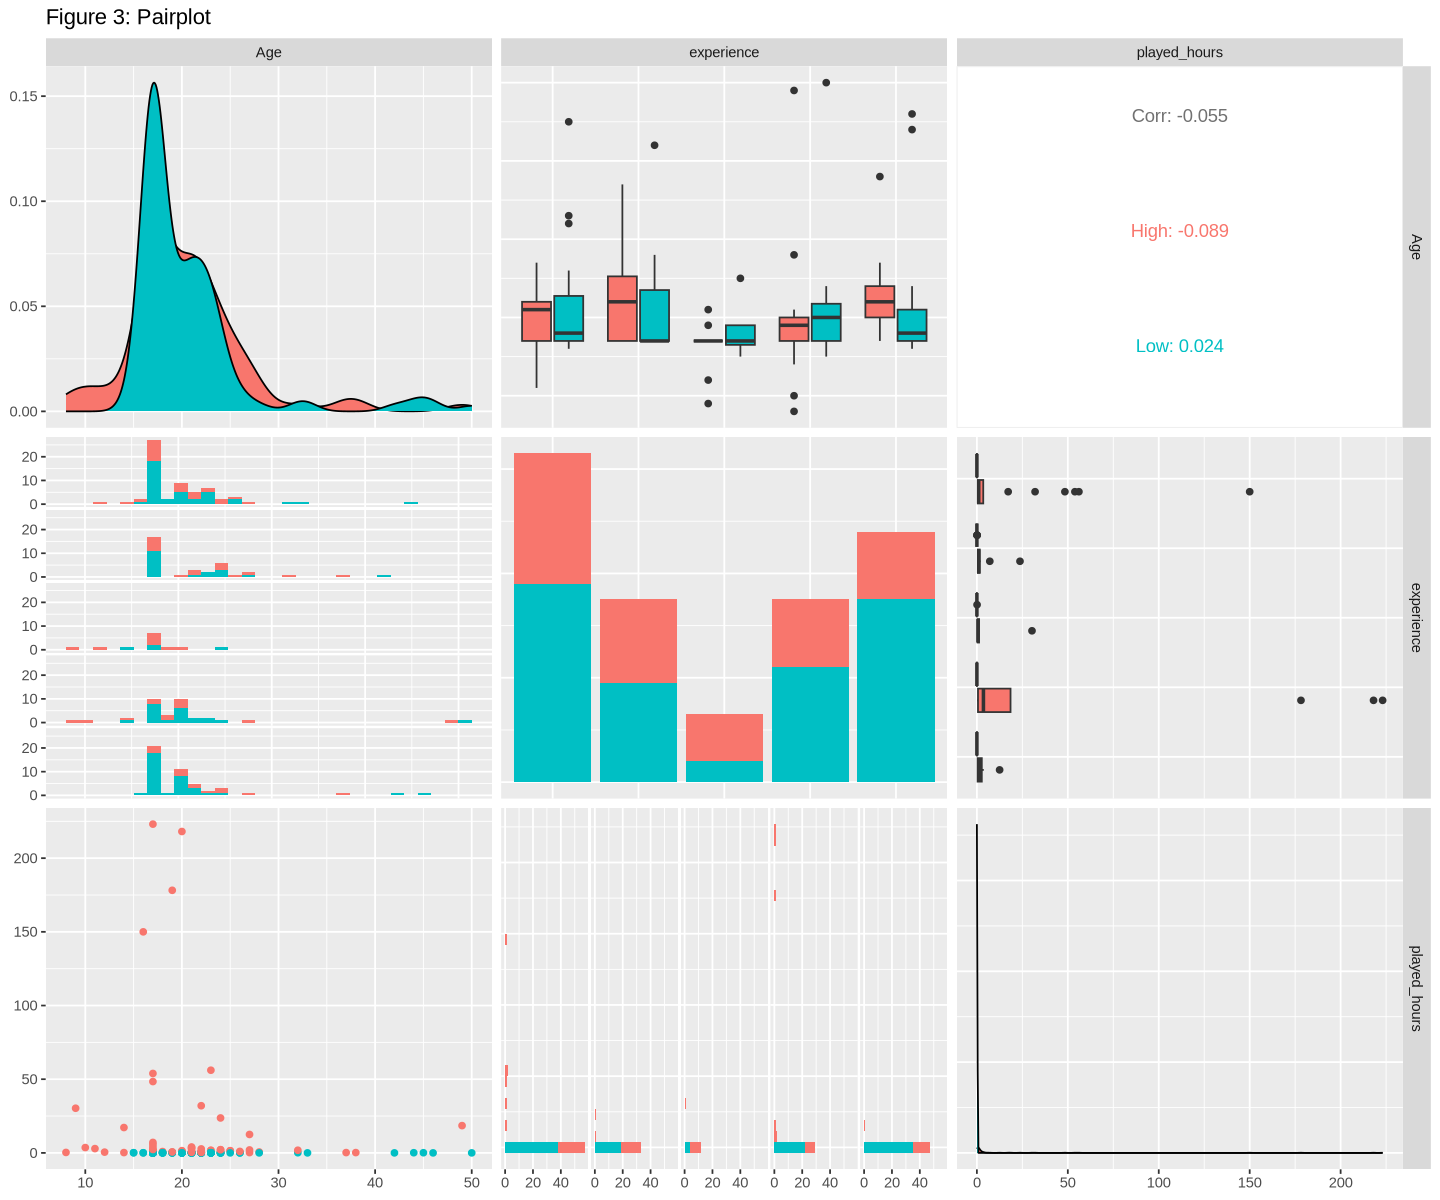

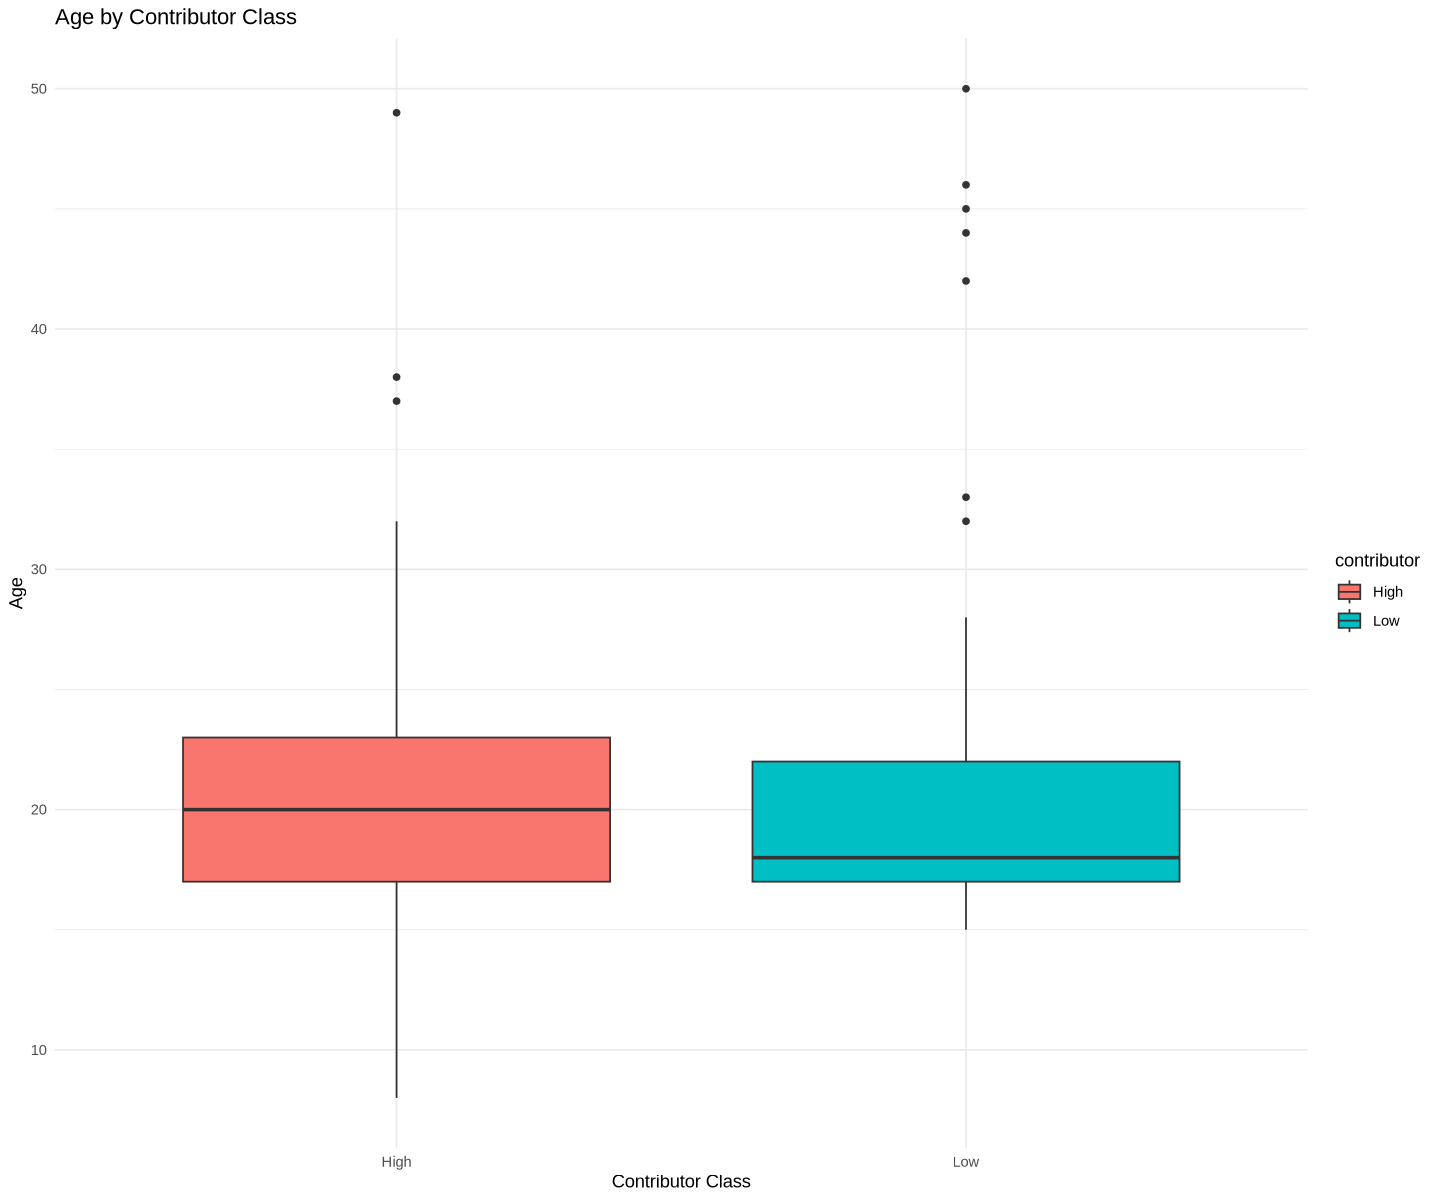

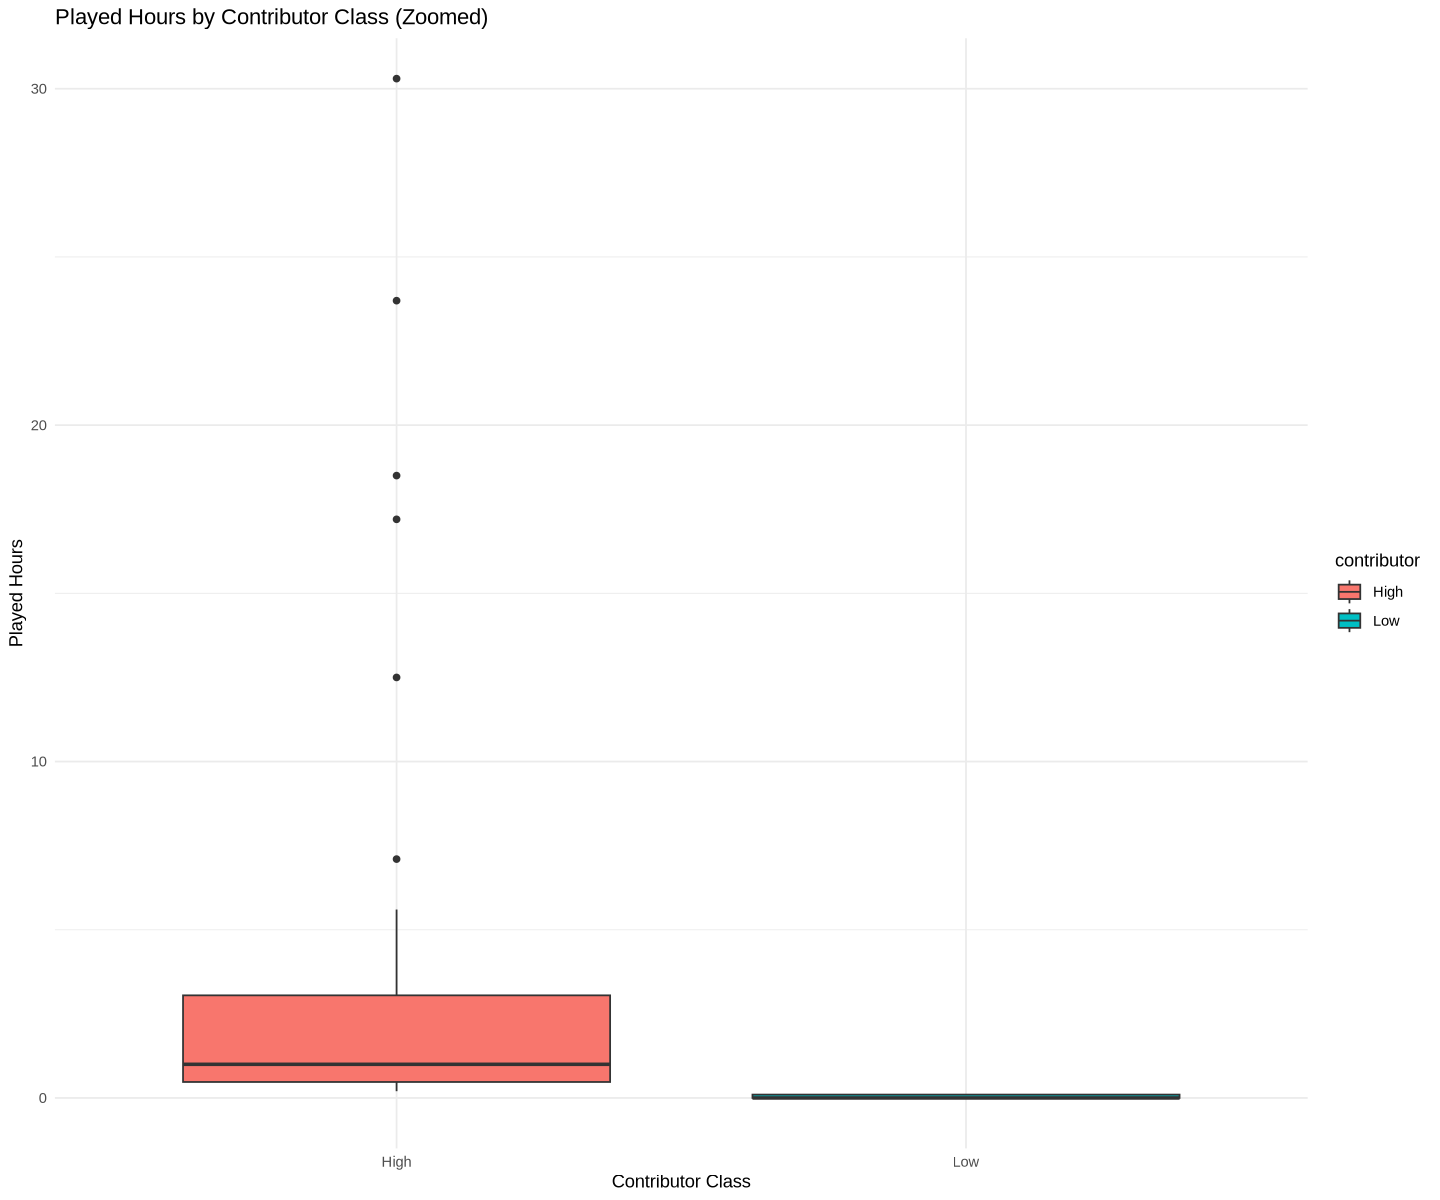

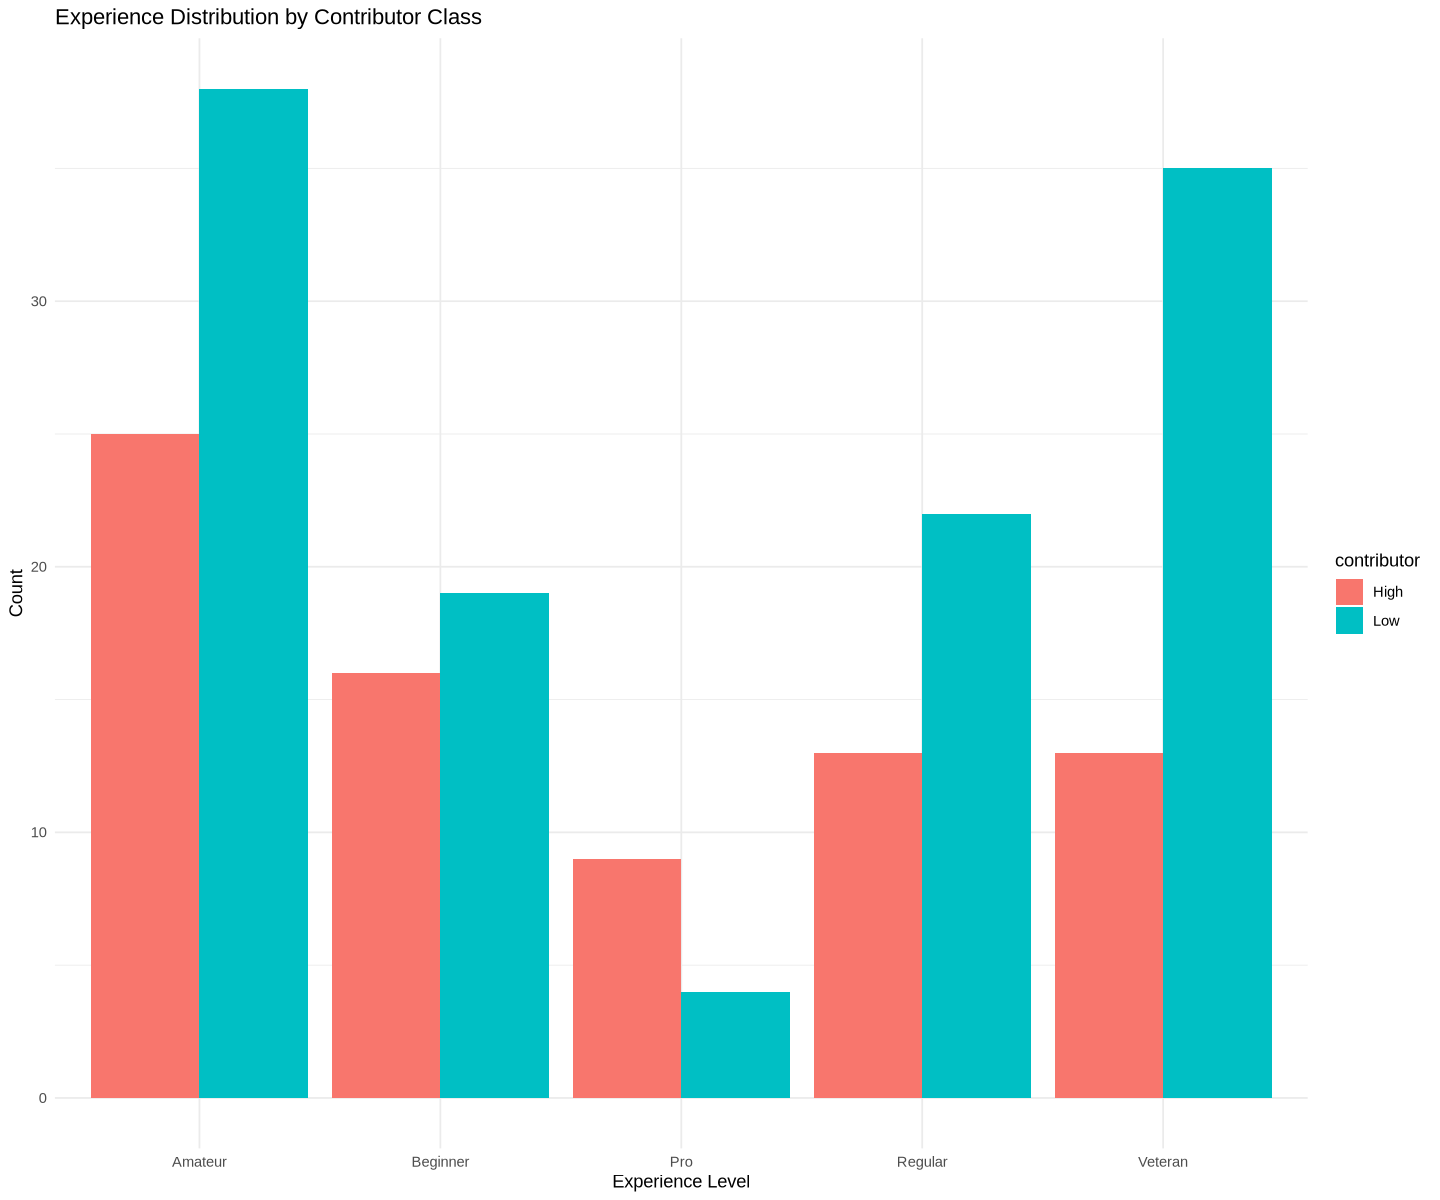

In [10]:
#Pairplot Visualization 3:

## note to kayleigh there are some things that look weird in the pairplot but its not neccesary to explain them, its the consequence of a pairplot
## basically the correlations can be explained, 
## it shows the correlations between hours and age based on contributions
## and the 3 plots below the pairplot (these are part of the pairplot but plotted individually just to actually see it better) are to be explained briefly.
## any help needed explaining lmk. 

ggpairs(players, mapping = aes(color = contributor), columns = c(1, 2, 3)) +
ggtitle("Figure 3: Pairplot")

# 4. Age distribution by contributor class
ggplot(players, aes(x = contributor, y = Age, fill = contributor)) +
  geom_boxplot() +
  labs(title = "Age by Contributor Class", y = "Age", x = "Contributor Class") +
  theme_minimal()

# 5. Played hours (zoomed in) boxplot
ggplot(players, aes(x = contributor, y = played_hours, fill = contributor)) +
  geom_boxplot() +
  coord_cartesian(ylim = c(0, 30)) +
  labs(title = "Played Hours by Contributor Class (Zoomed)", y = "Played Hours", x = "Contributor Class") +
  theme_minimal()

# 6. Experience level distribution (as a bar chart)
ggplot(players, aes(x = experience, fill = contributor)) +
  geom_bar(position = "dodge") +
  labs(title = "Experience Distribution by Contributor Class", x = "Experience Level", y = "Count") +
   theme_minimal()

## Creating KNN Classification Model

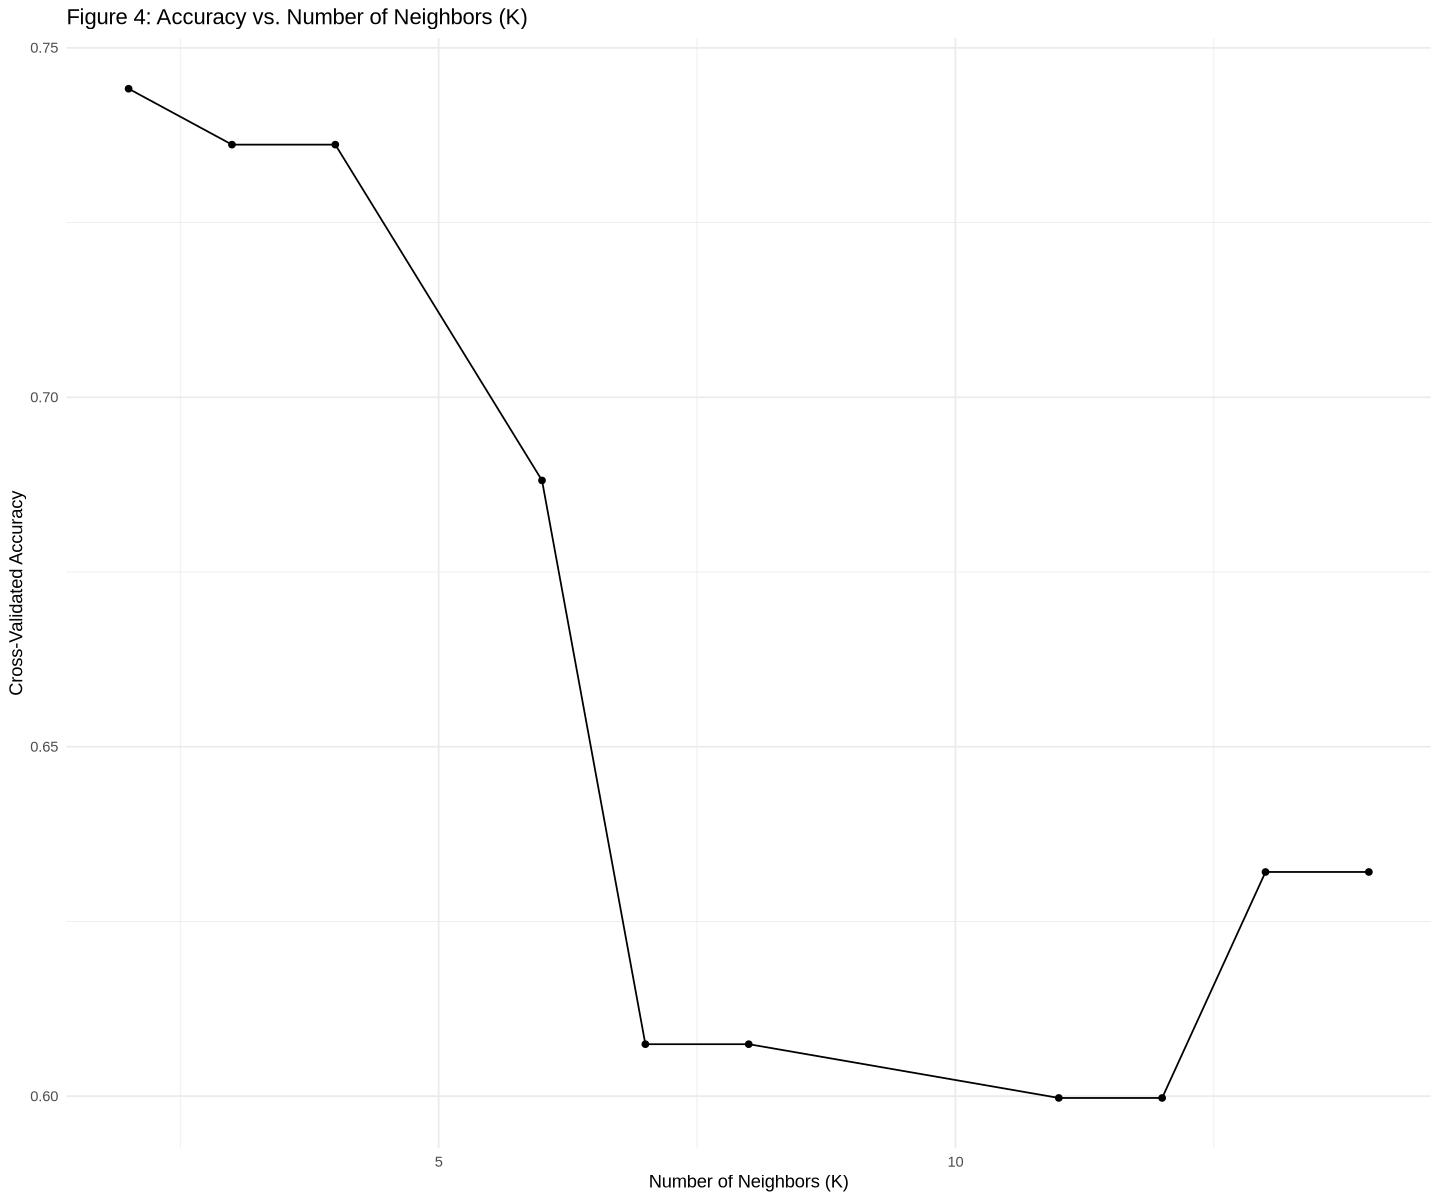

In [8]:
set.seed(123)

# 1. Preprocessing recipe
player_recipe <- recipe(contributor ~ Age + experience + played_hours, data = players_train) |>
  step_scale(all_numeric_predictors()) |>
  step_center(all_numeric_predictors())

# 2. Cross-validation
player_folds <- vfold_cv(players_train, v = 5, strata = contributor)

# 3. Tunable KNN model
knn_model <- nearest_neighbor(weight_func = "rectangular", neighbors = tune())|>
  set_engine("kknn") |>
  set_mode("classification")

# 4. Workflow
knn_workflow <- workflow() |>
  add_recipe(player_recipe) |>
  add_model(knn_model)

# 5. Tune K using grid search
knn_results <- tune_grid(
  knn_workflow,
  resamples = player_folds,
  grid = 10,
  metrics = metric_set(accuracy)
)

# 6. Plot accuracy vs. K
knn_accuracies <- knn_results |>
  collect_metrics()|>
  filter(.metric == "accuracy")

ggplot(knn_accuracies, aes(x = neighbors, y = mean)) +
  geom_point() +
  geom_line() +
  labs(
    title = "Figure 4: Accuracy vs. Number of Neighbors (K)",
    x = "Number of Neighbors (K)",
    y = "Cross-Validated Accuracy"
  ) +
  theme_minimal()

## Performing KNN Classification

In [9]:
# Select best k
best_knn <- knn_results |>
  select_best(metric = "accuracy")

# Finalize workflow
final_knn_workflow <- knn_workflow |>
  finalize_workflow(best_knn)

# Fit final model
final_knn_fit <- final_knn_workflow |>
  fit(data = players_train)

# Predict on test data
test_predictions <- predict(final_knn_fit, new_data = players_test) |>
  bind_cols(players_test)

# Accuracy & Kappa
knn_metrics <- test_predictions |>
  metrics(truth = contributor, estimate = .pred_class)
knn_metrics

# Confusion matrix
conf_mat_result <- conf_mat(
  data = test_predictions,
  truth = contributor,
  estimate = .pred_class
)
conf_mat_result

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.8405797
kap,binary,0.6631158


          Truth
Prediction High Low
      High   21   5
      Low     6  37

## Analysis of Accuracy and Confusion Matrix

## Strengths and Limitations of Model

## Discussion

Based on the results of our above analysis we found the precision of our model to be ~80% meaning 80% of the time our model was able to accurately classify the observations. This result shows that our model is able to accurately predict the playing hours of a player based on factors such as their age and experience which successfully answers our research question as well as shows these variables may influence eachother. These findings can be useful to help players understand how they can improve their contributions. In conclusion, our findings have answered our research question “Can experience and age predict the played hours in the player dataset?” However, it leaves us questioning what other variables we might be able to predict.